In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Dense, Conv1D, MaxPooling1D
from keras.layers import Flatten, Concatenate, Dropout, Reshape, BatchNormalization
from keras.models import Model





In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17911506539786769506
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 17288644404
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13279150230873812482
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [7]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]
# IC50evaluation//Dataset//Scenario3_EC-11K_znorm
workdir = "path"
dataset = np.load(workdir + "//191204_EC11K_z_norm.npz") # input file
ss0 = np.load(workdir + '//191204_EC11K_z_norm_r0_9_1.npz') # split for training and test

In [8]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [9]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [10]:
# In[15]:
ab =[]
for i in range(100,200):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

0 42


In [11]:
x.shape

(11360, 18988)

In [12]:
training_image_array.shape

(10224, 18988)

In [13]:
# In[21]: hyperparameter

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100


In [14]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [15]:
shape_value = train_X.shape[1]
print(shape_value)

18988


In [16]:
train_X_cell = train_X[:,:shape_value]
train_X_drug =train_X[:,shape_value:]
test_X_cell = test_X[:,:shape_value]
test_X_drug = test_X[:,shape_value:]

In [17]:
train_X_cell.shape

(10224, 18988)

In [18]:
train_X_cell = train_X_cell.reshape(train_X_cell.shape[0], train_X_cell.shape[1], 1)
train_X_drug = train_X_drug.reshape(train_X_drug.shape[0], train_X_drug.shape[1], 1)
test_X_cell = test_X_cell.reshape(test_X_cell.shape[0], test_X_cell.shape[1], 1)
test_X_drug = test_X_drug.reshape(test_X_drug.shape[0], test_X_drug.shape[1], 1)
#input_shape = (img_rows, img_cols, 1)

In [19]:
print(train_X_cell.shape,train_X_drug.shape, train_y.shape, test_X_cell.shape,test_X_drug.shape, test_y.shape)

(10224, 18988, 1) (10224, 0, 1) (10224,) (1136, 18988, 1) (1136, 0, 1) (1136,)


In [20]:
train_X_cell.shape

(10224, 18988, 1)

In [21]:
train_X_cell = train_X_cell.astype('float32')
test_X_cell = test_X_cell.astype('float32')
train_X_drug = train_X_drug.astype('float32')
test_X_drug = test_X_drug.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (10224, 18988)
10224 train samples
1136 test samples


In [22]:
# Model architecture
with K.tf.device('/GPU:0'):
    input_cell = Input(shape=(train_X_cell.shape[1], train_X_cell.shape[2]), name='cell_input')
#     input_drug = Input(shape=(train_X_drug.shape[1], train_X_drug.shape[2]), name='drug_input')

    conv_cell_line_1 = Conv1D(filters=50, kernel_size=700, strides=5, activation='tanh')(input_cell)
    maxpool_cell_line_1 = MaxPooling1D(pool_size=5)(conv_cell_line_1)
    conv_cell_line_2 = Conv1D(filters=30, kernel_size=5, strides=2, activation='relu')(maxpool_cell_line_1)
    maxpool_cell_line_2 = MaxPooling1D(pool_size=10)(conv_cell_line_2)
    flatten_cell_line = Flatten()(maxpool_cell_line_2)
    dense_cell_line = Dense(100, activation='relu')(flatten_cell_line)
    dropout_cell_line = Dropout(0.1)(dense_cell_line)

#     conv_drug_1 = Conv1D(filters=50, kernel_size=200, strides=3, activation='tanh')(input_drug)
#     maxpool_drug_1 = MaxPooling1D(pool_size=5)(conv_drug_1)
#     conv_drug_2 = Conv1D(filters=30, kernel_size=50, strides=5, activation='relu')(maxpool_drug_1)
#     maxpool_drug_2 = MaxPooling1D(pool_size=10)(conv_drug_2)
#     flatten_drug = Flatten()(maxpool_drug_2)
#     dense_drug = Dense(100, activation='relu')(flatten_drug)
#     dropout_drug = Dropout(0.1)(dense_drug)

#     concatenate = Concatenate()([dropout_cell_line, dropout_drug])
    dense_1 = Dense(300, activation='tanh')(dropout_cell_line)
    dropout_1 = Dropout(0.1)(dense_1)
    reshape_1 = Reshape((300,1))(dropout_1)
    conv_1 = Conv1D(filters=30, kernel_size=150, strides=1, activation='relu')(reshape_1)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    conv_2 = Conv1D(filters=10, kernel_size=5, strides=1, activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling1D(pool_size=3)(conv_2)
    conv_3 = Conv1D(filters=5, kernel_size=5, strides=1, activation='relu')(maxpool_2)
    maxpool_3 = MaxPooling1D(pool_size=3)(conv_3)
    dropout_2 = Dropout(0.1)(maxpool_3)
    flatten = Flatten()(dropout_2)
    dropout_3 = Dropout(0.2)(flatten)
    output = Dense(1, activation='linear', name='pred_lnIC50')(dropout_3)
    model = Model(inputs=[input_cell], outputs=output, name='MasterModel')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cell_input (InputLayer)      (None, 18988, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3658, 50)          35050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 731, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 364, 30)           7530      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 36, 30)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1080)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               108100    
__________

In [24]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [25]:
# Model fitting
optim = Adam(lr=0.0002)

model.compile(loss='mse',
		      optimizer=optim,
			  metrics=['mse','mae'])

StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with K.tf.device('/GPU:0'):
    model_train = model.fit(train_X_cell, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X_cell, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2019-12-05 16:18:08.689000
Instructions for updating:
Use tf.cast instead.
Train on 10224 samples, validate on 1136 samples
Epoch 1/150
10224/10224 [==============================] - 7s 716us/step - loss: 4.1137 - mean_squared_error: 4.1137 - mean_absolute_error: 1.6343 - val_loss: 4.2031 - val_mean_squared_error: 4.2031 - val_mean_absolute_error: 1.6030
Epoch 2/150
10224/10224 [==============================] - 3s 283us/step - loss: 4.0027 - mean_squared_error: 4.0027 - mean_absolute_error: 1.5777 - val_loss: 4.2488 - val_mean_squared_error: 4.2488 - val_mean_absolute_error: 1.5375
Epoch 3/150
10224/10224 [==============================] - 3s 289us/step - loss: 3.9618 - mean_squared_error: 3.9618 - mean_absolute_error: 1.5642 - val_loss: 4.2775 - val_mean_squared_error: 4.2775 - val_mean_absolute_error: 1.5061
Epoch 4/150
10224/10224 [==============================] - 3s 293us/step - loss: 3.9336 - mean_squared_error: 3.9336 - mean_absolute_error: 1.5521 - val_loss: 4.1783

10224/10224 [==============================] - 3s 290us/step - loss: 3.8080 - mean_squared_error: 3.8080 - mean_absolute_error: 1.5001 - val_loss: 4.2948 - val_mean_squared_error: 4.2948 - val_mean_absolute_error: 1.5840
Epoch 70/150
10224/10224 [==============================] - 3s 297us/step - loss: 3.7988 - mean_squared_error: 3.7988 - mean_absolute_error: 1.4985 - val_loss: 4.2732 - val_mean_squared_error: 4.2732 - val_mean_absolute_error: 1.6141
Epoch 71/150
10224/10224 [==============================] - 3s 296us/step - loss: 3.8081 - mean_squared_error: 3.8081 - mean_absolute_error: 1.5054 - val_loss: 4.2677 - val_mean_squared_error: 4.2677 - val_mean_absolute_error: 1.6287
Epoch 72/150
10224/10224 [==============================] - 3s 286us/step - loss: 3.8017 - mean_squared_error: 3.8017 - mean_absolute_error: 1.5001 - val_loss: 4.3211 - val_mean_squared_error: 4.3211 - val_mean_absolute_error: 1.5868
Epoch 73/150
10224/10224 [==============================] - 3s 286us/step - l

10224/10224 [==============================] - 3s 286us/step - loss: 3.7917 - mean_squared_error: 3.7917 - mean_absolute_error: 1.4925 - val_loss: 4.3021 - val_mean_squared_error: 4.3021 - val_mean_absolute_error: 1.6187
Epoch 105/150
10224/10224 [==============================] - 3s 287us/step - loss: 3.7833 - mean_squared_error: 3.7833 - mean_absolute_error: 1.4974 - val_loss: 4.3070 - val_mean_squared_error: 4.3070 - val_mean_absolute_error: 1.5958
Epoch 106/150
10224/10224 [==============================] - 3s 288us/step - loss: 3.7822 - mean_squared_error: 3.7822 - mean_absolute_error: 1.4916 - val_loss: 4.3045 - val_mean_squared_error: 4.3045 - val_mean_absolute_error: 1.6001
Epoch 107/150
10224/10224 [==============================] - 3s 287us/step - loss: 3.7870 - mean_squared_error: 3.7870 - mean_absolute_error: 1.4939 - val_loss: 4.3016 - val_mean_squared_error: 4.3016 - val_mean_absolute_error: 1.6094
Epoch 108/150
10224/10224 [==============================] - 3s 289us/step

Epoch 139/150
10224/10224 [==============================] - 3s 289us/step - loss: 3.7785 - mean_squared_error: 3.7785 - mean_absolute_error: 1.4893 - val_loss: 4.3156 - val_mean_squared_error: 4.3156 - val_mean_absolute_error: 1.5760
Epoch 140/150
10224/10224 [==============================] - 3s 290us/step - loss: 3.7851 - mean_squared_error: 3.7851 - mean_absolute_error: 1.4963 - val_loss: 4.3585 - val_mean_squared_error: 4.3585 - val_mean_absolute_error: 1.5850
Epoch 141/150
10224/10224 [==============================] - 3s 290us/step - loss: 3.7696 - mean_squared_error: 3.7696 - mean_absolute_error: 1.4856 - val_loss: 4.3240 - val_mean_squared_error: 4.3240 - val_mean_absolute_error: 1.5984
Epoch 142/150
10224/10224 [==============================] - 3s 289us/step - loss: 3.7771 - mean_squared_error: 3.7771 - mean_absolute_error: 1.4877 - val_loss: 4.3381 - val_mean_squared_error: 4.3381 - val_mean_absolute_error: 1.5960
Epoch 143/150
10224/10224 [==============================] -

In [26]:
import json
from keras.models import model_from_json, load_model
workdir = "E://Ronny_TF//DrugResponsivenessGuidelines//Experiments//191205_rerun//ResNet//Result//EC-11K//CNN"
# Option 1: Save Weights + Architecture
model.save_weights(workdir + '//EC11K_CNN_model_fix_v3.h5')
with open(workdir + '//EC11K_CNN_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [27]:
# Option 2: Save/Load the Entire Model
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//EC11K_CNN_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [28]:
test_eval = model.evaluate(test_X_cell, test_label_array, verbose=1)

1136/1136 [==============================] - 0s 308us/step


In [29]:
test_eval

[4.323612508639483, 4.323612508639483, 1.5996973531346925]

In [30]:
accuracy = model_train.history['mean_squared_error']
val_accuracy = model_train.history['val_mean_squared_error']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [31]:
np.savetxt("191205_EC_11k_CNN_cdr_master_tr_mse.csv", np_acc, delimiter=",")
np.savetxt("191205_EC_11k_CNN_cdr_master_val_mse.csv", np_val_acc, delimiter=",")
np.savetxt("191205_EC_11k_CNN_cdr_master_tr_loss.csv", np_loss, delimiter=",")
np.savetxt("191205_EC_11k_CNN_cdr_master_val_loss.csv", np_val_loss, delimiter=",")

In [32]:
import matplotlib
from matplotlib import pyplot as plt

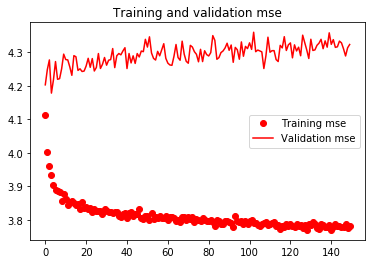

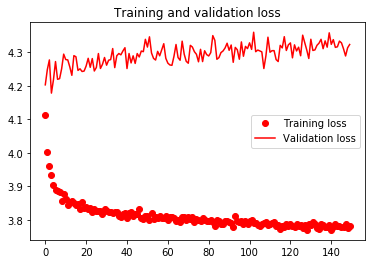

In [33]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse',c='red')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse',c='red')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss',c='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss',c='red')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [34]:
predicted_classes = model.predict(test_X_cell)

In [35]:
predicted_value = predicted_classes

In [36]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [37]:
c.to_csv(workdir + '//EC11K_CNN_Predicted_test_val_for_plot.csv')

In [38]:
c

,Predicted,Test
0,0.471217,-3.533074
1,1.122518,-0.203329
2,0.953262,-3.005719
3,1.300081,-4.800177
4,1.116044,2.079442
5,1.110386,2.079442
6,0.927981,0.886114
7,-1.295125,1.700495
8,0.561239,2.079442
9,0.585082,1.173165


In [39]:
predicted_value.shape

(1136, 1)

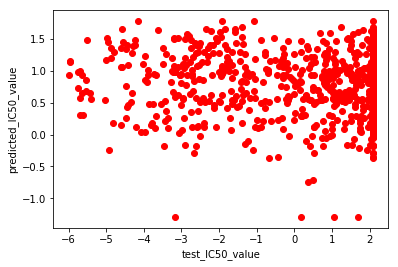

In [40]:
# scatter plot
plt.scatter(test_label_array,predicted_value,c='red')
plt.xlabel('test_IC50_value')
plt.ylabel('predicted_IC50_value')
plt.savefig(workdir + '//EDC11K_CNN_test_scatterplot.png')

In [41]:
# RMSE
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 2.0793298672139398


In [ ]:
# R-squared value

from sklearn.metrics import r2_score
r2_value = r2_score(b, a) 
print(r2_value)